## Etapa 1

- Identificar os conjuntos de dados de criminalidade disponíveis na Secretaria de Segurança
Pública.

- Baixar todos os datasets relevantes (ex.: diferentes séries de procedência, diferentes anos
ou categorias).

- Organizar os arquivos em pastas, nomeando de forma clara.


In [4]:
import pandas as pd
import numpy as np
# Carregando os datasets
df_2021 = pd.read_csv("./Dados Criminais 2021 - 2025/dados_2021.csv", sep=";", encoding="latin1", low_memory=False)
df_2022 = pd.read_csv("./Dados Criminais 2021 - 2025/dados_2022.csv", sep=";", encoding="latin1", low_memory=False)
df_2023 = pd.read_csv("./Dados Criminais 2021 - 2025/dados_2023.csv", sep=";", encoding="latin1", low_memory=False)
df_2024 = pd.read_csv("./Dados Criminais 2021 - 2025/dados_2024.csv", sep=";", encoding="latin1", low_memory=False)
df_2025 = pd.read_csv("./Dados Criminais 2021 - 2025/dados_2025.csv", sep=";", encoding="latin1", low_memory=False)

print("Datasets carregados:")
print("2021 ->", df_2021.shape, "linhas e colunas")
print("2022 ->", df_2022.shape, "linhas e colunas")
print("2023 ->", df_2023.shape, "linhas e colunas")
print("2024 ->", df_2024.shape, "linhas e colunas")
print("2025 ->", df_2025.shape, "linhas e colunas")

df_2022.head()


Datasets carregados:
2021 -> (166150, 136) linhas e colunas
2022 -> (599648, 118) linhas e colunas
2023 -> (806945, 124) linhas e colunas
2024 -> (758173, 127) linhas e colunas
2025 -> (504339, 136) linhas e colunas


,Sequência,Data Fato,Hora Fato,Grupo Fato,Tipo Enquadramento,Tipo Fato,Municipio Fato,Local Fato,Bairro,Quantidade Vítimas,...,Unnamed: 108,Unnamed: 109,Unnamed: 110,Unnamed: 111,Unnamed: 112,Unnamed: 113,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117
0,1,01/01/2022,00:01:00,CRIMES,OUTROS CRIMES,Consumado,BARRA DO RIBEIRO,OUTROS,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,01/01/2022,00:01:00,CRIMES,OUTROS CRIMES,Consumado,NOVO HAMBURGO,OUTROS,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,01/01/2022,00:01:00,CRIMES,INJURIA,Consumado,PORTO ALEGRE,RESIDENCIA,Santo Antônio,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,01/01/2022,00:01:00,CRIMES,ESTUPRO DE VULNERAVEL,Consumado,PORTO ALEGRE,RESIDENCIA,Partenon,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,01/01/2022,00:01:00,CRIMES,ESTELIONATO,Consumado,PROGRESSO,OUTROS,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Etapa 2

- Importar os arquivos em Python (pandas).
- Garantir que as colunas estejam padronizadas (nomes iguais, tipos de dados coerentes).
- Concatenar todos os dados de criminalidade em um único DataFrame.


In [11]:
# Concatenar em um único dataframe
df_crimes = pd.concat([df_2021, df_2022, df_2023, df_2024, df_2025], ignore_index=True)
print("Dataframe consolidado:", df_crimes.shape)
df_crimes.head()


Dataframe consolidado: (2835255, 136)


,Sequência,Data Fato,Hora Fato,Grupo Fato,Tipo Enquadramento,Tipo Fato,Municipio Fato,Local Fato,Bairro,Quantidade Vítimas,...,Unnamed: 126,Unnamed: 127,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135
0,1,01/10/2021,00:01:00,CRIMES,INCENDIO DOLOSO,Consumado,NOVA ALVORADA,RESIDENCIA,Jardim Bela Vista,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,01/10/2021,00:01:00,CRIMES,VIOLENCIA PSICOLOGICA CONTRA MULHER ART 147B,Consumado,SANTA CRUZ DO SUL,RESIDENCIA,Santa Vitória,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,01/10/2021,00:01:00,CRIMES,FURTO SIMPLES EM RESIDENCIA,Consumado,SANTA ROSA,RESIDENCIA,Cruzeiro,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,01/10/2021,00:01:00,CRIMES,IMPORTUNACAO SEXUAL,Consumado,RIO GRANDE,VIA PUBLICA,Vila Santa Tereza,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,01/10/2021,00:01:00,CRIMES,OUTRAS FRAUDES,Consumado,PORTO ALEGRE,VIA PUBLICA,Azenha,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
print("CHECKPOINT ETAPA 1 - COLETA DE DADOS")
print(f"Total de registros consolidados: {df_crimes.shape[0]:,}")
print(f"Total de colunas: {df_crimes.shape[1]}")
print("Arquivos coletados: dados_2021.csv, dados_2022.csv, dados_2023.csv, dados_2024.csv, dados_2025.csv")


CHECKPOINT ETAPA 1 - COLETA DE DADOS
Total de registros consolidados: 2,835,255
Total de colunas: 136
Arquivos coletados: dados_2021.csv, dados_2022.csv, dados_2023.csv, dados_2024.csv, dados_2025.csv


In [13]:
# Remover colunas 'unnamed' geradas por excesso de separadores ou células vazias
df_crimes = df_crimes.loc[:, ~df_crimes.columns.str.lower().str.startswith('unnamed')]

In [14]:
# Renomear colunas principais
df_crimes.rename(columns={
    "Sequência": "sequencia",
    "Data Fato": "data_fato", 
    "Hora Fato": "hora_fato",
    "Grupo Fato": "grupo_fato",
    "Tipo Enquadramento": "tipo_enquadramento",
    "Tipo Fato": "tipo_fato",
    "Municipio Fato": "municipio_fato",
    "Local Fato": "local_fato",
    "Bairro": "bairro",
    "Quantidade Vítimas": "quantidade_vitimas",
    "Idade Vítima": "idade_vitima",
    "Sexo Vítima": "sexo_vitima",
    "Cor Vítima": "cor_vitima",
}, inplace=True)
df_crimes


,sequencia,data_fato,hora_fato,grupo_fato,tipo_enquadramento,tipo_fato,municipio_fato,local_fato,bairro,quantidade_vitimas,idade_vitima,sexo_vitima,cor_vitima,...
0,1,01/10/2021,00:01:00,CRIMES,INCENDIO DOLOSO,Consumado,NOVA ALVORADA,RESIDENCIA,Jardim Bela Vista,1,20.0,Masculino,Branca,NaN
1,2,01/10/2021,00:01:00,CRIMES,VIOLENCIA PSICOLOGICA CONTRA MULHER ART 147B,Consumado,SANTA CRUZ DO SUL,RESIDENCIA,Santa Vitória,1,66.0,Feminino,Branca,NaN
2,3,01/10/2021,00:01:00,CRIMES,FURTO SIMPLES EM RESIDENCIA,Consumado,SANTA ROSA,RESIDENCIA,Cruzeiro,1,49.0,Feminino,Branca,NaN
3,4,01/10/2021,00:01:00,CRIMES,IMPORTUNACAO SEXUAL,Consumado,RIO GRANDE,VIA PUBLICA,Vila Santa Tereza,1,42.0,Feminino,Branca,NaN
4,5,01/10/2021,00:01:00,CRIMES,OUTRAS FRAUDES,Consumado,PORTO ALEGRE,VIA PUBLICA,Azenha,1,51.0,Feminino,Parda,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835250,504335,31/08/2025,23:50:00,CRIMES,DANO,Consumado,CAPAO DA CANOA,RESIDENCIA,Capao Novo/05,1,27.0,Feminino,Branca,NaN
2835251,504336,31/08/2025,23:50:00,CRIMES,FURTO DE TELEFONE CELULAR,Consumado,ESTEIO,OUTROS,NaN,1,43.0,Feminino,Branca,NaN
2835252,504337,31/08/2025,23:55:00,CRIMES,AMEACA,Consumado,PORTO ALEGRE,RESIDENCIA,Medianeira,1,53.0,Feminino,Branca,NaN
2835253,504338,31/08/2025,23:56:00,CRIMES,ESTELIONATO,Consumado,VIAMAO,RESIDENCIA,Sítio São José,0,NaN,NaN,NaN,NaN


## Etapa 3
- Tratar valores ausentes (decidir se preenche, exclui ou substitui).
- Remover duplicatas.
- Ajustar o formato de datas para um padrão único (YYYY-MM-DD).
- Corrigir inconsistências em colunas categóricas (ex.: "Homicídio" vs "homicidio").


In [16]:
# Filtrar apenas os dados de Passo Fundo
df_pf = df_crimes[df_crimes['municipio_fato'].str.upper() == 'PASSO FUNDO']
df_pf.head()

,sequencia,data_fato,hora_fato,grupo_fato,tipo_enquadramento,tipo_fato,municipio_fato,local_fato,bairro,quantidade_vitimas,idade_vitima,sexo_vitima,cor_vitima,...
6,7,01/10/2021,00:01:00,CRIMES,FURTO ABIGEATO,Consumado,PASSO FUNDO,OUTROS,ROD TRANSBRASILIANA,1,58.0,Masculino,Branca,NaN
61,65,01/10/2021,01:10:00,CRIMES,ENTORPECENTES - TRAFICO,Consumado,PASSO FUNDO,RESIDENCIA,Vila Popular,0,NaN,NaN,NaN,NaN
67,71,01/10/2021,01:19:00,CONTRAVENCOES,VIAS DE FATO,Consumado,PASSO FUNDO,RESIDENCIA,RODRIGUEZ,1,48.0,Feminino,Branca,NaN
150,162,01/10/2021,03:30:09,CRIMES,FURTO DE DOCUMENTO,Consumado,PASSO FUNDO,OUTROS,Centro,1,20.0,Feminino,Sem informação,NaN
170,188,01/10/2021,04:14:00,CONTRAVENCOES,PERTURBACAO DO TRABALHO OU DO SOSSEGO ALHEIOS,Consumado,PASSO FUNDO,RESIDENCIA,Vila Planaltina,0,NaN,NaN,NaN,NaN


In [17]:
# Remover a última coluna (vazia) dados vazios
df_pf = df_pf.iloc[:, :-1]  
print(f"Coluna vazia removida. Novo shape: {df_pf.shape}")

Coluna vazia removida. Novo shape: (59124, 13)


In [18]:
import unicodedata

# Normalizar texto (minúsculas, sem acentos, sem espaços)
df_pf = df_pf.applymap(
    lambda x: ''.join(
        c for c in unicodedata.normalize('NFKD', str(x).strip().lower()) 
        if not unicodedata.combining(c)
    ) if isinstance(x, str) else x
)
print("=== DADOS DE CRIMINALIDADE LIMPOS E PADRONIZADOS ===")
print(f"Shape: {df_pf.shape}")

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_8384\2402902436.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pf = df_pf.applymap(


=== DADOS DE CRIMINALIDADE LIMPOS E PADRONIZADOS ===
Shape: (59124, 13)


In [20]:
# Limpeza e padronização dos dados

# 1. Remover duplicatas
df_pf = df_pf.drop_duplicates()

# 2. Substituir "Sem informação" por NaN
df_pf.replace("sem informacao", np.nan, inplace=True)

# 3. Preencher colunas numéricas com a média
numericas = df_pf.select_dtypes(include=['int64', 'float64']).columns
df_pf[numericas] = df_pf[numericas].fillna(df_pf[numericas].mean())

# 4. Converter datas e horas
df_pf['data_fato'] = pd.to_datetime(df_pf['data_fato'], format='%d/%m/%Y', errors='coerce')
df_pf['hora_fato'] = pd.to_datetime(df_pf['hora_fato'], format='%H:%M:%S', errors='coerce').dt.time

# 5. Garantir que numéricas permaneçam numéricas
df_pf[numericas] = df_pf[numericas].apply(pd.to_numeric, errors='coerce')

# 6 Categóricas -> categoria Ignorado
df_pf['sexo_vitima'] = df_pf['sexo_vitima'].fillna("ignorado")
df_pf['cor_vitima']  = df_pf['cor_vitima'].fillna("ignorado")




In [21]:
df_pf.head()

,sequencia,data_fato,hora_fato,grupo_fato,tipo_enquadramento,tipo_fato,municipio_fato,local_fato,bairro,quantidade_vitimas,idade_vitima,sexo_vitima,cor_vitima
6,7,2021-10-01,00:01:00,crimes,furto abigeato,consumado,passo fundo,outros,rod transbrasiliana,1,58.000000,masculino,branca
61,65,2021-10-01,01:10:00,crimes,entorpecentes - trafico,consumado,passo fundo,residencia,vila popular,0,39.584217,ignorado,ignorado
67,71,2021-10-01,01:19:00,contravencoes,vias de fato,consumado,passo fundo,residencia,rodriguez,1,48.000000,feminino,branca
150,162,2021-10-01,03:30:09,crimes,furto de documento,consumado,passo fundo,outros,centro,1,20.000000,feminino,ignorado
170,188,2021-10-01,04:14:00,contravencoes,perturbacao do trabalho ou do sossego alheios,consumado,passo fundo,residencia,vila planaltina,0,39.584217,ignorado,ignorado


In [ ]:
df_pf.info()

In [ ]:
# --- Bloco de Correção de Tipos de Dados ---

# 1. Converter colunas numéricas principais
df_pf['sequencia'] = pd.to_numeric(df_pf['sequencia'], errors='coerce')
df_pf['quantidade_vitimas'] = pd.to_numeric(df_pf['quantidade_vitimas'], errors='coerce')
df_pf['idade_vitima'] = pd.to_numeric(df_pf['idade_vitima'], errors='coerce')

# 2. Preencher nulos apenas onde faz sentido
# Sequência e quantidade de vítimas não devem ficar nulos
df_pf[['sequencia', 'quantidade_vitimas']] = df_pf[['sequencia', 'quantidade_vitimas']].fillna(0)

# 3. Ajustar tipos definitivos
df_pf['sequencia'] = df_pf['sequencia'].astype(int)
df_pf['quantidade_vitimas'] = df_pf['quantidade_vitimas'].astype(int)
df_pf['idade_vitima'] = df_pf['idade_vitima'].round().astype('Int64')

# 4. Converter hora_fato para datetime.time
# Substituir strings inválidas por NaN
df_pf['hora_fato'] = df_pf['hora_fato'].replace(
    ['ignorado', 'sem informação', 'nao informado'], np.nan
)

# Tentar converter para datetime.time
df_pf['hora_fato'] = pd.to_datetime(df_pf['hora_fato'], format='%H:%M:%S', errors='coerce').dt.time

# Conferir resultados
print(df_pf['hora_fato'].unique()[:50])

# 5. Converter colunas categóricas para economizar memória
cat_cols = [
    'grupo_fato', 'tipo_enquadramento', 'tipo_fato',
    'municipio_fato', 'local_fato', 'bairro',
    'sexo_vitma', 'cor_vitma'
]
df_pf[cat_cols] = df_pf[cat_cols].astype('category')

# --- Verificação Final ---
print("Tipos de dados após a correção:")
df_pf.info()
print("\nExemplo de linhas:")
print(df_pf.head())


## Etapa 4 

- Importar o dataset meteorológico (fornecido pelo professor).
- Garantir que a coluna de data esteja no mesmo formato que o dataset de criminalidade.
- Fazer o merge dos datasets (chave: data + cidade = Passo Fundo).
- Garantir que nenhuma coluna gerou dados vazios. Caso alguma informação esteja vazia,
- preencher com alguma informação consistente.


In [ ]:
import pandas as pd

caminho_meteo = r"C:\Users\Eduardo\Documents\Codes\dados-criminalidade-meteorologia\Dados meteo\passo_fundo_meteriologia.csv"

# Ler o CSV pulando as linhas de metadados
df_meteo = pd.read_csv(
    caminho_meteo, 
    sep=';', 
    decimal=',',          # para interpretar vírgula como decimal
    skiprows=9,           # pula as 9 primeiras linhas de metadados
    encoding='latin1'
)

# Conferir as primeiras linhas
print(df_meteo.head())


In [ ]:
df_meteo.head()

In [ ]:
df_meteo.shape

In [ ]:
# Remover colunas 'unnamed' vazias
df_meteo = df_meteo.drop(columns=['Unnamed: 6'])


In [ ]:
# Renomear a coluna de data
df_meteo.rename(columns={'Data Medicao': 'data'}, inplace=True)

# Converter para datetime e padronizar formato YYYY-MM-DD (igual df_pf)
df_meteo['data'] = pd.to_datetime(df_meteo['data'], errors='coerce').dt.strftime('%Y-%m-%d')


In [ ]:
# 1. Garantir que a coluna de data está em datetime
df_pf['data_fato'] = pd.to_datetime(df_pf['data_fato'], errors='coerce')
df_meteo['data'] = pd.to_datetime(df_meteo['data'], errors='coerce')

# 2. Merge usando data como chave
df_merged = pd.merge(
    df_pf, 
    df_meteo, 
    left_on='data_fato', 
    right_on='data', 
    how='inner'
)

# 3. Conferir resultado
print(f"Crimes: {df_pf.shape}, Meteorologia: {df_meteo.shape}, Merge: {df_merged.shape}")
df_merged.head()


In [ ]:
# Remover a coluna 'data' duplicada (mantendo 'data_fato')
df_merged = df_merged.drop('data', axis=1)

# Verificar o resultado final
print("=== DATASET INTEGRADO ===")
print(f"Shape final: {df_merged.shape}")
print(f"Período: {df_merged['data_fato'].min()} a {df_merged['data_fato'].max()}")
print("\nPrimeiras linhas:")
df_merged.head()

In [ ]:
# Preencher dados meteorológicos vazios com 0
df_merged['PRECIPITACAO TOTAL, DIARIO (AUT)(mm)'].fillna(0, inplace=True)
df_merged['TEMPERATURA MAXIMA, DIARIA (AUT)(Â°C)'].fillna(20, inplace=True)  
df_merged['TEMPERATURA MINIMA, DIARIA (AUT)(Â°C)'].fillna(10, inplace=True)
df_merged['UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)'].fillna(60, inplace=True)
df_merged['VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)'].fillna(5, inplace=True)

print("Dados preenchidos! Verificando...")
print("Dados vazios restantes:", df_merged.isnull().sum().sum())

In [88]:
# TESTE. Verificar dados vazios no dataset integrado
print("ver dados vazios")
print("Valores nulos por coluna:")
print(df_merged.isnull().sum())

print("\nPercentual de dados vazios:")
percentual_vazios = (df_merged.isnull().sum() / len(df_merged)) * 100
print(percentual_vazios[percentual_vazios > 0])

ver dados vazios
Valores nulos por coluna:
sequencia                                           0
data_fato                                           0
hora_fato                                           0
grupo_fato                                          0
tipo_enquadramento                                  0
tipo_fato                                           0
municipio_fato                                      0
local_fato                                          0
bairro                                           6547
quantidade_vitimas                                  0
idade_vitima                                        0
sexo_vitma                                          0
cor_vitma                                           0
PRECIPITACAO TOTAL, DIARIO (AUT)(mm)                0
TEMPERATURA MAXIMA, DIARIA (AUT)(Â°C)               0
TEMPERATURA MINIMA, DIARIA (AUT)(Â°C)               0
UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)       0
VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/

In [ ]:
# TESTE. Ver informações básicas do dataset final
print("=== INFORMAÇÕES DO DATASET FINAL ===")
print(f"Total de registros: {len(df_merged):,}")
print(f"Total de colunas: {df_merged.shape[1]}")
print(f"Período: {df_merged['data_fato'].min()} até {df_merged['data_fato'].max()}")
print("\nPrimeiras 5 linhas:")
df_merged.head()

=== INFORMAÇÕES DO DATASET FINAL ===
Total de registros: 59,124
Total de colunas: 18
Período: 2021-10-01 00:00:00 até 2025-08-31 00:00:00

Primeiras 5 linhas:


,sequencia,data_fato,hora_fato,grupo_fato,tipo_enquadramento,tipo_fato,municipio_fato,local_fato,bairro,quantidade_vitimas,idade_vitima,sexo_vitma,cor_vitma,"PRECIPITACAO TOTAL, DIARIO (AUT)(mm)","TEMPERATURA MAXIMA, DIARIA (AUT)(Â°C)","TEMPERATURA MINIMA, DIARIA (AUT)(Â°C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)","VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)"
0,7,2021-10-01,00:01:00,crimes,furto abigeato,consumado,passo fundo,outros,rod transbrasiliana,1,58,masculino,branca,10.6,23.0,15.6,91.6,3.1
1,65,2021-10-01,01:10:00,crimes,entorpecentes - trafico,consumado,passo fundo,residencia,vila popular,0,40,ignorado,ignorado,10.6,23.0,15.6,91.6,3.1
2,71,2021-10-01,01:19:00,contravencoes,vias de fato,consumado,passo fundo,residencia,rodriguez,1,48,feminino,branca,10.6,23.0,15.6,91.6,3.1
3,162,2021-10-01,03:30:09,crimes,furto de documento,consumado,passo fundo,outros,centro,1,20,feminino,ignorado,10.6,23.0,15.6,91.6,3.1
4,188,2021-10-01,04:14:00,contravencoes,perturbacao do trabalho ou do sossego alheios,consumado,passo fundo,residencia,vila planaltina,0,40,ignorado,ignorado,10.6,23.0,15.6,91.6,3.1


In [89]:
# TESTE. Verificar se os dados fazem sentido
print("=== VERIFICAÇÃO DE RELEVÂNCIA ===")
print("Tipos de crimes mais comuns:")
print(df_merged['tipo_fato'].value_counts().head())

print("\nEstatísticas das variáveis meteorológicas:")
colunas_meteo = ['PRECIPITACAO TOTAL, DIARIO (AUT)(mm)', 
                'TEMPERATURA MAXIMA, DIARIA (AUT)(Â°C)', 
                'TEMPERATURA MINIMA, DIARIA (AUT)(Â°C)']
print(df_merged[colunas_meteo].describe())

=== VERIFICAÇÃO DE RELEVÂNCIA ===
Tipos de crimes mais comuns:
tipo_fato
consumado    59124
Name: count, dtype: int64

Estatísticas das variáveis meteorológicas:
       PRECIPITACAO TOTAL, DIARIO (AUT)(mm)  \
count                          59124.000000   
mean                               5.316531   
std                               13.855323   
min                                0.000000   
25%                                0.000000   
50%                                0.000000   
75%                                2.600000   
max                              153.600000   

       TEMPERATURA MAXIMA, DIARIA (AUT)(Â°C)  \
count                           59124.000000   
mean                               24.755265   
std                                 5.586633   
min                                 6.000000   
25%                                20.900000   
50%                                25.100000   
75%                                29.200000   
max                           

In [90]:
# TESTE. Teste simples de correlação
print("=== TESTE DE RELEVÂNCIA ===")
print("Crimes por dia em média:", len(df_merged) / df_merged['data_fato'].nunique())
print("Dias únicos com dados:", df_merged['data_fato'].nunique())

=== TESTE DE RELEVÂNCIA ===
Crimes por dia em média: 41.316561844863735
Dias únicos com dados: 1431


In [91]:
# TESTE. Ver se tem correlação básica
crimes_por_dia = df_merged.groupby('data_fato').size()
print(f"Dia com mais crimes: {crimes_por_dia.max()} crimes")
print(f"Dia com menos crimes: {crimes_por_dia.min()} crimes")

Dia com mais crimes: 79 crimes
Dia com menos crimes: 14 crimes


#### possiveis preocupações


bairros vazios, ver como tratar



In [92]:
# Filtra o DataFrame para mostrar apenas as linhas onde 'bairro' é nulo
linhas_vazias = df_merged[df_merged['bairro'].isnull()]

# Exibe as primeiras 10 linhas desse filtro
print("Exibindo as primeiras 10 linhas onde o bairro é nulo:")
display(linhas_vazias.head(10))

Exibindo as primeiras 10 linhas onde o bairro é nulo:


,sequencia,data_fato,hora_fato,grupo_fato,tipo_enquadramento,tipo_fato,municipio_fato,local_fato,bairro,quantidade_vitimas,idade_vitima,sexo_vitma,cor_vitma,"PRECIPITACAO TOTAL, DIARIO (AUT)(mm)","TEMPERATURA MAXIMA, DIARIA (AUT)(Â°C)","TEMPERATURA MINIMA, DIARIA (AUT)(Â°C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)","VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)"
12,513,2021-10-01,09:00:00,crimes,estelionato,consumado,passo fundo,outros,NaN,1,25,feminino,branca,10.6,23.0,15.6,91.6,3.1
20,880,2021-10-01,10:50:00,crimes,outras fraudes,consumado,passo fundo,outros,NaN,0,40,ignorado,ignorado,10.6,23.0,15.6,91.6,3.1
21,895,2021-10-01,11:00:00,crimes,exercicio arbitrario proprias razoes,consumado,passo fundo,hospitais/clinicas,NaN,1,53,feminino,branca,10.6,23.0,15.6,91.6,3.1
30,1426,2021-10-01,15:00:00,crimes,difamacao,consumado,passo fundo,outros,NaN,1,57,feminino,branca,10.6,23.0,15.6,91.6,3.1
32,1587,2021-10-01,15:45:00,crimes,violar a suspensao ou proibicao de dirigir vei...,consumado,passo fundo,via publica,NaN,0,40,ignorado,ignorado,10.6,23.0,15.6,91.6,3.1
35,1695,2021-10-01,16:30:00,crimes,"permitir,confiar,ou entreg. direcao a pessoa s...",consumado,passo fundo,via publica,NaN,0,40,ignorado,ignorado,10.6,23.0,15.6,91.6,3.1
58,2804,2021-10-02,04:00:00,crimes,furto em veiculo,consumado,passo fundo,via publica,NaN,1,19,masculino,branca,0.0,24.0,13.3,83.2,2.8
72,3502,2021-10-02,14:00:00,crimes,lesao corporal,consumado,passo fundo,outros,NaN,1,14,feminino,branca,0.0,24.0,13.3,83.2,2.8
84,4015,2021-10-02,18:56:00,crimes,lesao corporal,consumado,passo fundo,via publica,NaN,1,22,masculino,preta,0.0,24.0,13.3,83.2,2.8
89,4246,2021-10-02,21:00:00,crimes,lesao corporal,consumado,passo fundo,via publica,NaN,1,32,feminino,branca,0.0,24.0,13.3,83.2,2.8


Para verificar ainda e testar

# Verificar dados vazios no dataset integrado
print("ver dados vazios")
print("Valores nulos por coluna:")
print(df_merged.isnull().sum())

print("\nPercentual de dados vazios:")
percentual_vazios = (df_merged.isnull().sum() / len(df_merged)) * 100
print(percentual_vazios[percentual_vazios > 0])


# 2. Ver informações básicas do dataset final
print("=== INFORMAÇÕES DO DATASET FINAL ===")
print(f"Total de registros: {len(df_merged):,}")
print(f"Total de colunas: {df_merged.shape[1]}")
print(f"Período: {df_merged['data_fato'].min()} até {df_merged['data_fato'].max()}")
print("\nPrimeiras 5 linhas:")
df_merged.head()

# 3. Verificar se os dados fazem sentido
print("=== VERIFICAÇÃO DE RELEVÂNCIA ===")
print("Tipos de crimes mais comuns:")
print(df_merged['tipo_fato'].value_counts().head())

print("\nEstatísticas das variáveis meteorológicas:")
colunas_meteo = ['PRECIPITACAO TOTAL, DIARIO (AUT)(mm)', 
                'TEMPERATURA MAXIMA, DIARIA (AUT)(Â°C)', 
                'TEMPERATURA MINIMA, DIARIA (AUT)(Â°C)']
print(df_merged[colunas_meteo].describe())

# 4. Teste simples de correlação
print("=== TESTE DE RELEVÂNCIA ===")
print("Crimes por dia em média:", len(df_merged) / df_merged['data_fato'].nunique())
print("Dias únicos com dados:", df_merged['data_fato'].nunique())

# Ver se tem correlação básica
crimes_por_dia = df_merged.groupby('data_fato').size()
print(f"Dia com mais crimes: {crimes_por_dia.max()} crimes")
print(f"Dia com menos crimes: {crimes_por_dia.min()} crimes")

In [ ]:
# Tratamento de bairros nulos (exemplo: marcar como 'desconhecido')
if df_merged['bairro'].isna().any():
    df_merged['bairro'] = df_merged['bairro'].fillna('desconhecido')
    df_merged['bairro'] = df_merged['bairro'].astype('category')

## ETAPA 5 

- Converter variáveis categóricas em numéricas ou ajustar as informações categóricas para
reduzir o ruído/excesso (funções personalizadas).
- Detectar e tratar outliers (usar IQR ou outra técnica).
- Aplicar normalização ou padronização das variáveis numéricas (min-max scaling, z-score
ou outra técnica).


---

In [32]:
import pandas as pd
import numpy as np
import unicodedata
from sklearn.preprocessing import MinMaxScaler

# --- 1. Padronizar colunas categóricas ---
remover_acentos = lambda x: ''.join(
    c for c in unicodedata.normalize('NFKD', str(x)) if not unicodedata.combining(c)
)

cat_cols = [
    'grupo_fato', 'tipo_enquadramento', 'tipo_fato',
    'municipio_fato', 'local_fato', 'bairro',
    'sexo_vitma', 'cor_vitma'
]

# Filtrar apenas colunas existentes
cat_cols_existentes = [col for col in cat_cols if col in df_pf.columns]

# Padronizar texto: string, minúsculas, sem espaços e sem acentos
df_pf[cat_cols_existentes] = (
    df_pf[cat_cols_existentes]
    .astype(str)
    .fillna('ignorado')
    .apply(lambda col: col.str.strip().str.lower().apply(remover_acentos))
)

# Converter categorias para números (Label Encoding via factorize)
for col in cat_cols_existentes:
    df_pf[col] = pd.factorize(df_pf[col])[0]

# --- 2. Tratar outliers nas colunas numéricas ---
num_cols = ['idade_vitima', 'quantidade_vitimas', 'sequencia']  # adicione outras numéricas se houver
num_cols_existentes = [col for col in num_cols if col in df_pf.columns]

for col in num_cols_existentes:
    # Apenas colunas numéricas
    df_pf[col] = pd.to_numeric(df_pf[col], errors='coerce')
    Q1 = df_pf[col].quantile(0.25)
    Q3 = df_pf[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    # Substituir outliers pelos limites
    df_pf[col] = df_pf[col].clip(lower=limite_inferior, upper=limite_superior)

# --- 3. Normalizar variáveis numéricas ---
scaler = MinMaxScaler()
df_pf[num_cols_existentes] = scaler.fit_transform(df_pf[num_cols_existentes])

# --- 4. Verificação final ---
print("Tipos de dados após transformação:")
print(df_pf.dtypes)
print("\nExemplo de linhas transformadas:")
print(df_pf.head())


Tipos de dados após transformação:
sequencia                    float64
data_fato             datetime64[ns]
hora_fato                     object
grupo_fato                     int64
tipo_enquadramento             int64
tipo_fato                      int64
municipio_fato                 int64
local_fato                     int64
bairro                         int64
quantidade_vitimas           float64
idade_vitima                 float64
sexo_vitima                    int64
cor_vitima                     int64
dtype: object

Exemplo de linhas transformadas:
     sequencia  data_fato hora_fato  grupo_fato  tipo_enquadramento  \
6     0.000000 2021-10-01  00:01:00           0                   0   
61    0.000072 2021-10-01  01:10:00           0                   1   
67    0.000079 2021-10-01  01:19:00           1                   2   
150   0.000192 2021-10-01  03:30:09           0                   3   
170   0.000224 2021-10-01  04:14:00           1                   4   

     tipo

essa 5 ai veio do gpt full n entendi nada

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_8384\3976999928.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


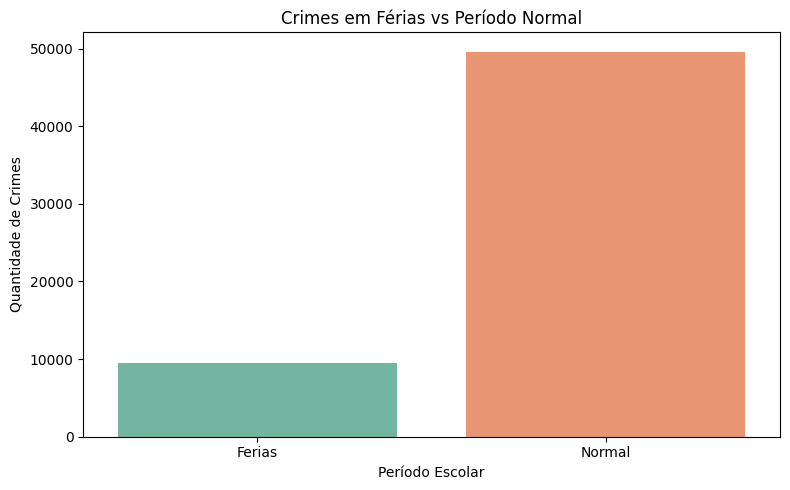

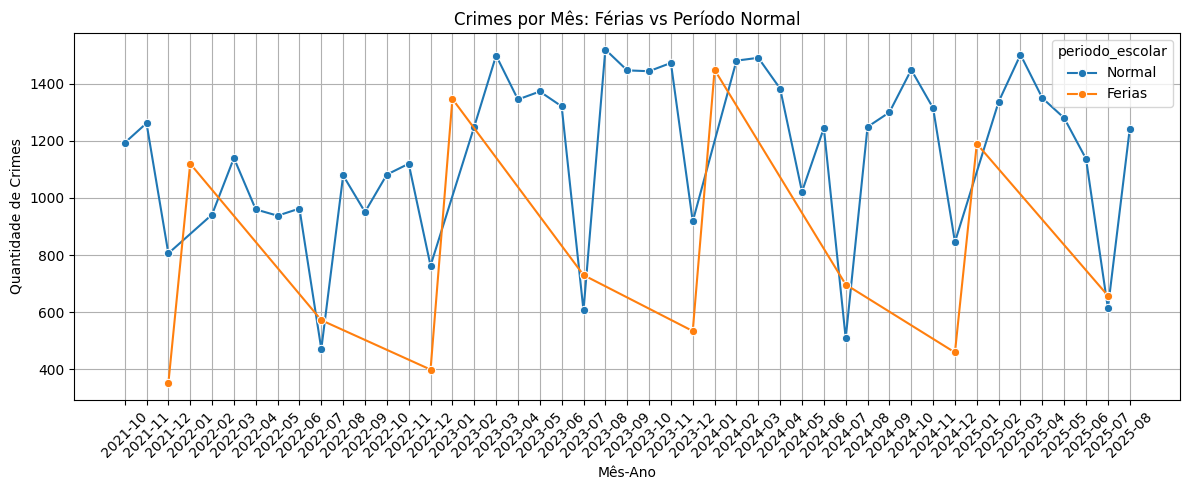

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Garantir que 'data_fato' seja datetime ---
df_pf['data_fato'] = pd.to_datetime(df_pf['data_fato'], errors='coerce')

# --- Criar coluna de período: férias ou normal ---
def periodo_ferias(data):
    if data is pd.NaT:
        return 'Normal'
    mes = data.month
    dia = data.day
    # Férias de verão: 20/12 a 31/01
    if (mes == 12 and dia >= 20) or (mes == 1):
        return 'Ferias'
    # Férias de inverno: 15/07 a 31/07
    elif mes == 7 and dia >= 15:
        return 'Ferias'
    else:
        return 'Normal'

df_pf['periodo_escolar'] = df_pf['data_fato'].apply(periodo_ferias)

# --- Agrupar crimes por período ---
crimes_periodo = df_pf.groupby('periodo_escolar').size().reset_index(name='quantidade_crimes')

# --- Visualização ---
plt.figure(figsize=(8,5))
sns.barplot(
    data=crimes_periodo,
    x='periodo_escolar',
    y='quantidade_crimes',
    palette='Set2'
)
plt.title("Crimes em Férias vs Período Normal")
plt.xlabel("Período Escolar")
plt.ylabel("Quantidade de Crimes")
plt.tight_layout()
plt.show()

# --- Comparação detalhada mês a mês ---
df_pf['mes_ano'] = df_pf['data_fato'].dt.to_period('M')

# Converter Period para string para o Seaborn
df_pf['mes_ano_str'] = df_pf['mes_ano'].astype(str)

crimes_mensais = df_pf.groupby(['mes_ano_str', 'periodo_escolar']).size().reset_index(name='quantidade_crimes')

plt.figure(figsize=(12,5))
sns.lineplot(
    data=crimes_mensais,
    x='mes_ano_str',
    y='quantidade_crimes',
    hue='periodo_escolar',
    marker='o'
)
plt.title("Crimes por Mês: Férias vs Período Normal")
plt.xlabel("Mês-Ano")
plt.ylabel("Quantidade de Crimes")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
